In [14]:
# import library
import pandas as pd
import numpy as np 
import matlab 
import matplotlib.pyplot as plt
import os
import numpy as np
from gc import callbacks
import scipy.linalg as la
from sklearn import preprocessing
from distfit import distfit
from sklearn.decomposition import PCA
import sys 
from scipy.optimize import curve_fit
import scipy.constants as constants 

In [15]:
# define prediction parameters
max_year = 2021
pred_year = 2100
num_of_pred = 200

In [16]:
# import data
path = r'data/UNPopulation Data .csv'
df = pd.read_csv(path)

# clean up birth data
births = [i.replace(" ", "") for i in df['Total Births (Thousands) '].values]
births = np.array(births).astype('float')
# clean up total population data
total_population = [i.replace(" ", "") for i in df['Total Population (Thousands)'].values]
total_population = np.array(total_population).astype('float')
# clean up mortality data
deaths = [i.replace(" ", '') for i in df['Total Deaths (Thousands) '].values]
deaths = np.array(deaths).astype('float')
df_year_array = [i for i in df['Year'].values]

In [17]:
# predict fertility rate 
df['Fertility Rate'] = births / total_population
change = df['Fertility Rate'].values[1:] - df['Fertility Rate'].values[:-1]
dist = distfit()
dist.fit_transform(change)
f_pred = []
for i in range(num_of_pred):
    f_pred.append(dist.generate(pred_year - max_year))
    
# predict mortality rate
df['Death Rate'] = deaths / total_population
change = df['Death Rate'].values[1:] - df['Death Rate'].values[:-1]
dist = distfit()
dist.fit_transform(change)
d_pred = []
for i in range(num_of_pred):
    d_pred.append(dist.generate(pred_year - max_year))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 553784] [loc=-0.000 scale=0.001]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 1.82322e+06] [loc=-0.002 scale=0.001]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 1.82322e+06] [loc=-131072.002 scale=131072.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 160397] [loc=-0.000 scale=0.000]
[distfit] >INFO> [t         ] [0.01 sec] [RSS: 102931] [loc=-0.000 scale=0.000]
[distfit] >INFO> [genextreme] [0.03 sec] [RSS: 497067] [loc=-0.001 scale=0.001]
[distfit] >INFO> [gamma     ] [0.01 sec] [RSS: 2.45772e+06] [loc=-0.002 scale=1.553]
[distfit] >INFO> [lognorm   ] [0.01 sec] [RSS: 446929] [loc=-0.003 scale=0.003]
[distfit] >INFO> [beta      ] [0.02 sec] [RSS: 507651] [loc=-0.002 scale=1377.378]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 1.89981e+06] [loc=-0.002 scale=0.005]
[distfit] >INFO> [loggamma  ] [0.01 sec] [RSS: 608782] [loc=-0.182 scale=0.025]
[distfit] >INFO> Compute confidence int

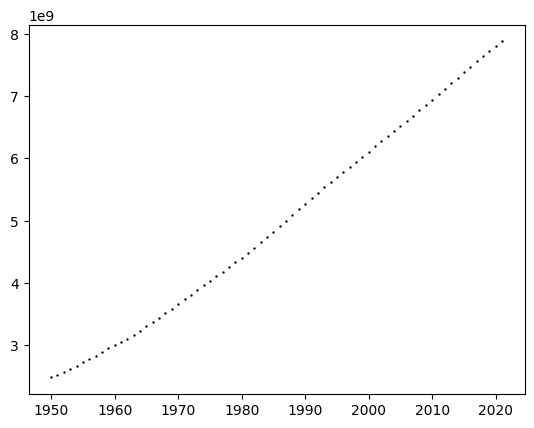

In [18]:
# historical data graph
plt.scatter(df['Year'], total_population * 1000, s = 0.5, color = 'black')

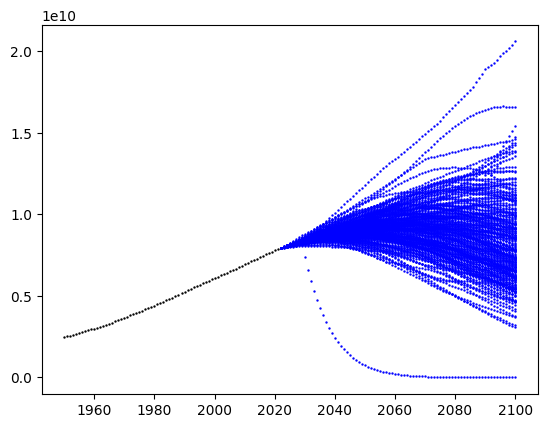

In [19]:
# raw prediction
plt.scatter(df['Year'], total_population * 1000, s = 0.5, color = 'black', label = 'data')

pop_array = []
year_array = []
births_array = []
deaths_array = []

for i in range (num_of_pred):
    pop = 7876932
    fertility = 0.017009
    death = 0.008791
    curr_year = 2021
    d = d_pred[i]
    f = f_pred[i]
    for j in range (pred_year - max_year):
        curr_d = d[j]
        curr_f = f[j]
        fertility += curr_f
        death += curr_d
        curr_year += 1
        pop = pop + pop * fertility - pop * death
        births_array.append(fertility * pop)
        deaths_array.append(death * pop)
        pop_array.append(pop)
        year_array.append(curr_year)
pop_array = np.array(pop_array)
year_array = np.array(year_array)
plt.scatter(year_array, pop_array * 1000, color = 'blue', s = 0.5, label = 'Prediction')

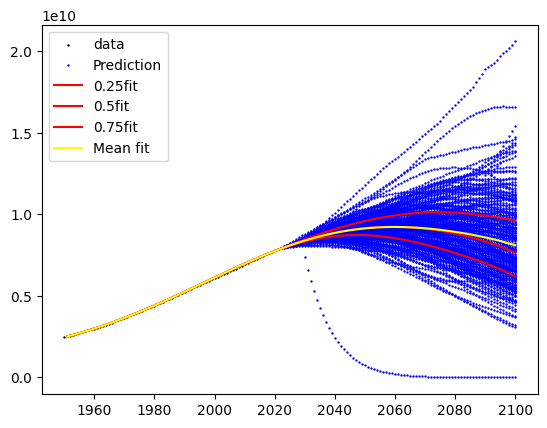

In [20]:
# prediction with the 4 quantile fit, and the mean fit 
plt.scatter(df['Year'], total_population * 1000, s = 0.5, color = 'black', label = 'data')
plt.scatter(year_array, pop_array * 1000, color = 'blue', s = 0.5, label = 'Prediction')

pop_array_fixed = np.concatenate((total_population, pop_array))
year_array_fixed = np.concatenate((df['Year'], year_array))

fixed_df = pd.DataFrame({
    'Pop': pop_array_fixed,
    'Year':year_array_fixed
})

quantile = [0.25, 0.5, 0.75]
for q in quantile:

    xdata = []
    ydata = []

    for year in range(1951, pred_year + 1):
        working_df = fixed_df[fixed_df['Year'] == year] 
        working_pop_array = working_df['Pop'].values
        q1 = np.quantile(working_pop_array, q)
        xdata.append(year)
        ydata.append(q1)
    
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    
    coef = np.polyfit(xdata,ydata,10)
    poly1d_fn = np.poly1d(coef) 
    y_fit = poly1d_fn(xdata)
    fit = f'{q}fit'
    plt.plot(xdata, y_fit * 1000, '-', color = 'red', label = fit)

xdata = []
ydata = []

for year in range(1951, pred_year + 1):
   working_df = fixed_df[fixed_df['Year'] == year] 
   working_pop_array = working_df['Pop'].values
   q1 = np.mean(working_pop_array)
   xdata.append(year)
   ydata.append(q1)
   
coef = np.polyfit(xdata,ydata,10)
poly1d_fn = np.poly1d(coef) 
y_fit = poly1d_fn(xdata)
plt.plot(xdata, y_fit * 1000, '-', color = 'Yellow', label = 'Mean fit')
plt.legend()

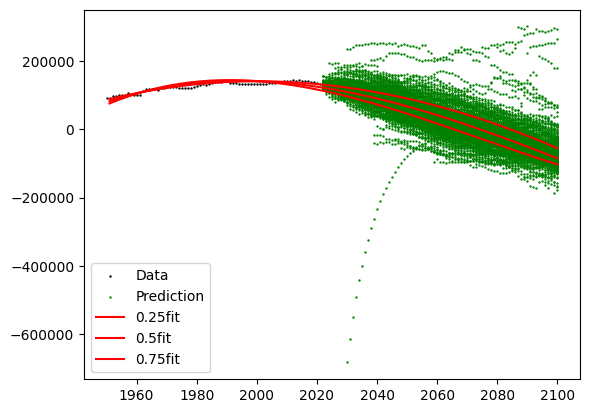

In [21]:
# fertility prediction and quantile fit 
plt.scatter(df_year_array, births, color = 'black', label = 'Data', s = 0.5)

births_array = np.array(births_array)
plt.scatter(year_array, births_array, color = 'green', label = 'Prediction', s = 0.5)

fertility_fixed = np.concatenate((births, births_array))
year_array_fixed = np.concatenate((df['Year'], year_array))

fixed_df = pd.DataFrame({
    'Pop': fertility_fixed,
    'Year':year_array_fixed
})

quantile = [0.25, 0.5, 0.75]
for q in quantile:

    xdata = []
    ydata = []

    for year in range(1951, pred_year + 1):
        working_df = fixed_df[fixed_df['Year'] == year] 
        working_pop_array = working_df['Pop'].values
        q1 = np.quantile(working_pop_array, q)
        xdata.append(year)
        ydata.append(q1)
    
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    
    coef = np.polyfit(xdata,ydata,3)
    poly1d_fn = np.poly1d(coef) 
    y_fit = poly1d_fn(xdata)
    fit = f'{q}fit'
    plt.plot(xdata, y_fit, '-', color = 'red', label = fit)

plt.legend()

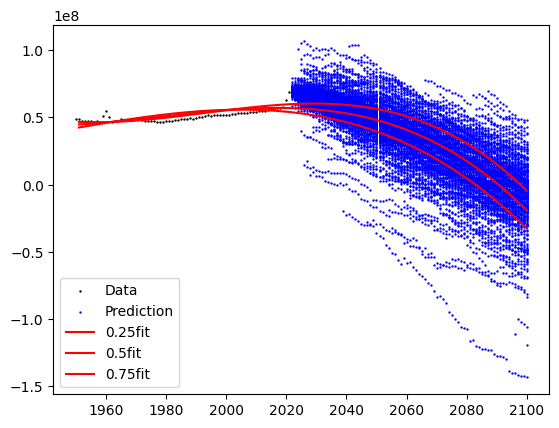

In [22]:
# mortality with quantile fit 
plt.scatter(df_year_array, deaths * 1000, color = 'black', label = 'Data', s = 0.5)

deaths_array = np.array(deaths_array)
plt.scatter(year_array, deaths_array * 1000, color = 'blue', label = 'Prediction', s = 0.5)

deaths_fixed = np.concatenate((deaths * 1000, deaths_array * 1000))
year_array_fixed = np.concatenate((df['Year'], year_array))

fixed_df = pd.DataFrame({
    'Pop': deaths_fixed,
    'Year':year_array_fixed
})

quantile = [0.25, 0.5, 0.75]
for q in quantile:

    xdata = []
    ydata = []

    for year in range(1951, pred_year + 1):
        working_df = fixed_df[fixed_df['Year'] == year] 
        working_pop_array = working_df['Pop'].values
        q1 = np.quantile(working_pop_array, q)
        xdata.append(year)
        ydata.append(q1)
    
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    
    coef = np.polyfit(xdata,ydata,3)
    poly1d_fn = np.poly1d(coef) 
    y_fit = poly1d_fn(xdata)
    fit = f'{q}fit'
    plt.plot(xdata, y_fit, '-', color = 'red', label = fit)
plt.legend()